# Extracting binary features from confusion matrices

A binary feature for n items is coded as an array of n binary values. This script finds the k best features from all x<sup>n-1</sup> possible features to describe all the items by considering mutual entropies between the input feature and output, and the mutual information between the input features.

## Definitions

In [1]:
import numpy as np
import pandas as pd
import json
from itertools import combinations, combinations_with_replacement
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def mutual_information(matrix):
    """Calculating mutual information from tabulated data"""
    total = matrix.sum()
    flatM = matrix.ravel()
    margin0 = matrix.sum(axis=0)
    margin1 = matrix.sum(axis=1)
    divisor = np.outer(margin1,margin0).ravel()
    indices = flatM.nonzero()
    return np.sum(flatM[indices]/total*np.log2(flatM[indices]*total/divisor[indices]))

def mutual_arrays(a1,a2):
    """Calculating mutual information from 2 arrays"""
    u1 = list(set(a1))
    u2 = list(set(a2))
    ar = np.zeros([len(u1),len(u2)])
    for i in range(len(a1)):
        ar[u1.index(a1[i]),u2.index(a2[i])]+=1
    return mutual_information(ar)
    
def mutual_x_y(matrix,feature, output_grouping = True): 
    """Tabulating data based on a feature and the outcome from the full confusion matrix. 
    If output_grouping is True, the outcome is also grouped based on the feature"""
    if output_grouping:
        indices0 = []
        indices1 = []
        for i,v in enumerate(feature):
            if v:
                indices1.append(i)
            else:
                indices0.append(i)

        matrix_xy = np.array([[matrix[np.ix_(indices0,indices0)].sum(),
                          matrix[np.ix_(indices1,indices0)].sum()],
                         [matrix[np.ix_(indices0,indices1)].sum(),
                          matrix[np.ix_(indices1,indices1)].sum()]])
    else:
        a0 = matrix[:,feature].sum(axis=1)
        a1 = matrix[:,np.invert(feature)].sum(axis=1)
        matrix_xy = np.vstack([a0,a1]).transpose()
        
    return mutual_information(matrix_xy)
    

def mutual_xi_xj(counts, indices_i1, indices_j1):
    """Tabulating the input based on two features"""
    indices_i0 = np.invert(indices_i1)
    indices_j0 = np.invert(indices_j1)

    matrix_xx = np.array([[counts[indices_i0&indices_j0].sum(),
                      counts[indices_i1&indices_j0].sum()],
                     [counts[indices_i0&indices_j1].sum(),
                      counts[indices_i1&indices_j1].sum()]])
    return mutual_information(matrix_xx)


def mutual_xi_xj_Y(cm, indices_i1, indices_j1): 
    """Calculating conditional mutual information"""
    mi = 0
    for r in range(cm.ny):
        mi+= cm.py[r]*mutual_xi_xj(cm.matrix[r,], indices_i1, indices_j1)
    return mi

def J(cm,k,method):
    indices = cm.order
    selected = np.array([],dtype='int')
    
    for i in range(k):
        best = 0
        j_max = 0
        for j in range(len(indices)):
            f = indices[j]
            I_xx = 0
            I_xx_Y = 0
            j_x = cm.MI_xy[f]
            for s in selected:
                if f < s:       
                    a = f
                    b = s
                else:
                    a = s
                    b = f
                j_x += method(cm,(a,b),I_xx,I_xx_Y,len(selected)) 
            if j_x > j_max:
                j_max = j_x
                best = j
        selected = np.append(selected, indices[best])
        indices=np.delete(indices,best)
    return selected
    
def mRMR(cm,p,I_xx,I_xx_Y,n):
    """To maximize MI_xy - (1/k) * MI_xx (Peng et al., 2005)"""
    if not p in cm.MI_xx:
        cm.MI_xx[p] = mutual_xi_xj(cm.x_counts,cm.features[p[0]],cm.features[p[1]])                  
    I_xx += cm.MI_xx[p]
    if I_xx:
        I_xx = I_xx/n

    return  -I_xx

def custom(cm,p,I_xx,I_xx_Y,n):
    """customized J(x) with MI_xx = 1"""
    if not p in cm.MI_xx:
        cm.MI_xx[p] = mutual_xi_xj(cm.x_counts,cm.features[p[0]],cm.features[p[1]])                  
    I_xx += cm.MI_xx[p]
    return -I_xx

    
def DCSF(cm,p,I_xx,I_xx_Y,n):
    """(Gao et al., 2018)"""
    if not p in cm.MI_xx:
        cm.MI_xx[p] = mutual_xi_xj(cm.x_counts,cm.features[p[0]],cm.features[p[1]]) 
    if not p in cm.MI_xx_Y:
        cm.MI_xx_Y[p] = mutual_xi_xj_Y(cm,cm.features[p[0]],cm.features[p[1]]) 
    I_xx += cm.MI_xx[p]
    I_xx_Y += cm.MI_xx_Y[p]
    if I_xx:
        I_xx = I_xx/n
        I_xx_Y = I_xx_Y/n

    return -3 * I_xx + 2 * I_xx_Y

def DCSF_b3g2(cm,p,I_xx,I_xx_Y,n):
    """beta = 3 gamma = 2 (Gao et al., 2018)"""
    if not p in cm.MI_xx:
        cm.MI_xx[p] = mutual_xi_xj(cm.x_counts,cm.features[p[0]],cm.features[p[1]]) 
    if not p in cm.MI_xx_Y:
        cm.MI_xx_Y[p] = mutual_xi_xj_Y(cm,cm.features[p[0]],cm.features[p[1]]) 
    I_xx += cm.MI_xx[p]
    I_xx_Y += cm.MI_xx_Y[p]

    return -3 * I_xx + 2 * I_xx_Y

def JMI(cm,p,I_xx,I_xx_Y,n):
    """(Yang and Moody, 2000)"""
    if not p in cm.MI_xx:
        cm.MI_xx[p] = mutual_xi_xj(cm.x_counts,cm.features[p[0]],cm.features[p[1]]) 
    if not p in cm.MI_xx_Y:
        cm.MI_xx_Y[p] = mutual_xi_xj_Y(cm,cm.features[p[0]],cm.features[p[1]]) 
    I_xx += cm.MI_xx[p]
    I_xx_Y += cm.MI_xx_Y[p]
    if I_xx:
        I_xx = I_xx/n
        I_xx_Y = I_xx_Y/n
    
    return  -I_xx + I_xx_Y
    
class confusion_matrix:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, index_col=0)
        self.df.reindex(sorted(self.df.index), axis=0)
        self.df.reindex(sorted(self.df.columns), axis=1)
        
        self.matrix = self.df.to_numpy()
        self.x_counts = self.matrix.sum(axis=0)
        self.n = self.matrix.shape[0]
        self.ny = self.matrix.shape[1]
        self.n_features = 2**(self.n-1)
        self.py = self.matrix.sum(axis=1)/self.matrix.sum()
        self.results = {}
        self.selected_features = {}
        self.same_items= {}
        self.results_resampled = {}
        
        self.MI_xy = np.array([])
        self.MI_xx = {}
        # Uppercase Y means Y is the conditioning variable
        self.MI_xx_Y = {}
                
    def not_diff(self, method):
        results = self.results[method]
        self.same_items[method]=[]
        for i in range(len(results)):
            j = results[i]
            f = self.features[j]
            if not i:
                fs = f
            else:
                fs = np.vstack([fs, f])
        
        for i in range(fs.shape[1]):
            for j in range(i+1,fs.shape[1]):
                if (fs[:,i]==fs[:,j]).all():
                    self.same_items[method].append([self.df.index[i],self.df.index[j]])
        

    def select(self, feature_lim = None, k = False, method = "DCSF", output_grouping = False):
        
        
        self.features = np.array([[j=='1' 
                                   for j in '1'+np.binary_repr(i, width=self.n-1)] 
                                   for i in range(self.n_features)])
        
        if self.MI_xy.size==0:     
            print('Computing I(x;y)')

            for i in tqdm(range(self.n_features)):
                self.MI_xy= np.append(self.MI_xy,mutual_x_y(self.matrix,self.features[i],output_grouping))

        self.order = np.arange(self.n_features, dtype='int')  
      
        
        if not k:
            k = int(np.ceil(np.log2(self.n)))
            self.same_items[method]=True
            print('Selecting features to differentiate all items with {}'.format(method))
            print('Number of features being selected: ',end='')
            while bool(self.same_items[method]):
                if k > self.n:
                    break
                print('{} '.format(k),end='')
                exec('self.results[method] = J(self,{},{})'.format(k,method))
                self.not_diff(method)
                k+=1
            self.selected_features[method] = \
                np.array([list('1'+np.binary_repr(j, width=self.n-1)) for j in self.results[method]]\
                               ,dtype=int)
            print('')
        else:
            print('Selecting {} features with {}'.format(k,method))
            exec('self.results[method] = J(self,{},{})'.format(k,method))
            self.not_diff(method)
            self.selected_features[method] = \
                np.array([list('1'+np.binary_repr(j, width=self.n-1)) for j in self.results[method]]\
                               ,dtype=int)
        
#         self.results[method] = self.results[method][np.argsort(-self.MI_xy[self.results[method]])]
        
    def show_selected(self, method):
        results = self.results[method]
        print('Printing {} selected features:'.format(len(results)))
        print('  | '+(' | ').join(production.df.index)+ ' | MI_xy')
        
        for i in range(len(results)):
            j = results[i]
                
            print('{:<2}'.format(i+1)+'| '+
                  ' | '.join(('x'+np.binary_repr(j, width=self.n-1)).replace('1','x').replace('0',' '))+ 
                  ' | {:.4f}'.format(self.MI_xy[j]))
    
        print('\n'+'-'*40)
        print('\nPairs of items that cannot be differentiated with the selected features:')

        if bool(self.same_items[method]):
            for i in self.same_items[method]:
                print(i)
        else:
            print('None!')
    
    def plot_pca(self,method):
        '''plot the first 4 principle components'''
        feature = self.selected_features[method].transpose()
        feature = StandardScaler().fit_transform(feature)
        pca = PCA(n_components = 4)
        pcs = pca.fit_transform(feature)
        tags = self.df.index
                           
                           
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
                           
        ax1.scatter(pcs[:,0], pcs[:,1])
        ax2.scatter(pcs[:,2], pcs[:,3])                 
        for i, tag in enumerate(tags):
            ax1.annotate(tag, (pcs[i,0]+0.04, pcs[i,1]+0.04))
            ax2.annotate(tag, (pcs[i,2]+0.04, pcs[i,3]+0.04))  
        
        ax1.set_xlabel('PC 1')
        ax1.set_ylabel('PC 2')
        ax2.set_xlabel('PC 3')
        ax2.set_ylabel('PC 4')
        fig.suptitle('PCs for '+method)
        plt.subplots_adjust(top=0.85)
        plt.tight_layout(pad=0.4, w_pad=0.5)  
             
    def plot_articulatory_feature_MI(self,art):
        for method,features in self.selected_features.items():
            df = []
            ind = []
            for i in range(len(features)):
                ind.append(method+str(i+1))
                MIs = {}
                for a,v in art.iterrows():
                    v = list(v)
                    MIs[a]= mutual_arrays(features[i],v)
                df.append(MIs)
            df = pd.DataFrame(df,index=ind)
            fig, ax = plt.subplots(figsize=[20,5])
            sns.heatmap(ax=ax,data=df, annot=True)

            
#     def select_with_resampling(self, feature_lim = None, k = False, \
#                                method = "DCSF", output_grouping = False, \
#                                n_resampling = 5):
        
#         self.features = np.array([[j=='1' 
#                                    for j in '1'+np.binary_repr(i, width=self.n-1)] 
#                                    for i in range(self.n_features)])
#         print('Resampling '+n_resampling+' times.')
#         for i in tqdm(range(n_resampling)):
            
#             MI_xy = 0
#             for i in range(self.n_features):
#                 MI_xy= np.append(MI_xy,mutual_x_y(self.matrix,self.features[i],output_grouping))

#             self.order = np.arange(self.n_features, dtype='int')  


#             if not k:
#                 k = int(np.ceil(np.log2(self.n)))
#                 self.same_items[method]=True
#                 print('Selecting features to differentiate all items with {}'.format(method))
#                 print('Number of features being selected: ',end='')
#                 while bool(self.same_items[method]):
#                     if k > self.n:
#                         break
#                     print('{} '.format(k),end='')
#                     exec('self.results[method] = J(self,{},{})'.format(k,method))
#                     self.not_diff(method)
#                     k+=1
#                 self.selected_features[method] = \
#                     np.array([list('1'+np.binary_repr(j, width=self.n-1)) for j in self.results[method]]\
#                                    ,dtype=int)
#                 print('')
#             else:
#                 print('Selecting {} features with {}'.format(k,method))
#                 exec('self.results[method] = J(self,{},{})'.format(k,method))
#                 self.not_diff(method)
#                 self.selected_features[method] = \
#                     np.array([list('1'+np.binary_repr(j, width=self.n-1)) for j in self.results[method]]\
#                                    ,dtype=int)

## Selection with original outcomes

### production

In [3]:
production = confusion_matrix('cm_production.csv')
production.select(method = 'DCSF')
production.select(method = 'DCSF_b3g2')
production.select(method = 'mRMR')
production.select(method = 'JMI')
production.select(method = 'custom')

Computing I(x;y)


  0%|          | 0/32768 [00:00<?, ?it/s]

Selecting features to differentiate all items with DCSF
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 
Selecting features to differentiate all items with DCSF_b3g2
Number of features being selected: 4 5 6 7 8 9 10 
Selecting features to differentiate all items with mRMR
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with JMI
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with custom
Number of features being selected: 4 5 6 7 


### perception

In [4]:
perception = confusion_matrix('cm_perception.csv')
perception.select(method='DCSF')
perception.select(method='DCSF_b3g2')
perception.select(method='mRMR')
perception.select(method='JMI')
perception.select(method='custom')

Computing I(x;y)


  0%|          | 0/32768 [00:00<?, ?it/s]

Selecting features to differentiate all items with DCSF
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with DCSF_b3g2
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with mRMR
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with JMI
Number of features being selected: 4 5 6 7 8 9 10 11 12 13 14 15 16 
Selecting features to differentiate all items with custom
Number of features being selected: 4 5 6 7 8 


## Selected features

### production

In [5]:
production.show_selected('DCSF')

Printing 13 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x | x |   |   | x |   | x | x |   | x | x |   |   |   |   | x | 0.3730
3 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.4554
4 | x | x |   | x | x |   |   |   | x | x | x |   | x | x |   |   | 0.3564
5 | x | x | x | x | x |   |   |   | x |   |   |   |   |   | x | x | 0.3256
6 | x | x |   |   | x | x |   |   |   |   |   | x | x | x |   | x | 0.3510
7 | x | x | x |   | x | x |   |   |   | x | x | x |   |   | x |   | 0.3764
8 | x |   | x | x |   |   |   |   | x | x | x | x | x | x |   |   | 0.3595
9 | x |   | x |   |   | x |   |   |   |   | x |   |   | x |   | x | 0.2562
10| x |   | x | x |   |   |   | x | x | x | x | x |   | x |   |   | 0.2705
11| x |   |   |   |   | x |   | x |   | x |   |   | x | x |   | x | 0.2323
12| x | x | x |   | x |   |   | x | x |   |   | x | x | x | x | x | 0.

In [6]:
production.show_selected('DCSF_b3g2')

Printing 10 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x | x |   |   | x |   | x | x |   | x | x |   |   |   |   | x | 0.3730
3 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.4554
4 | x |   | x |   |   | x | x | x |   | x | x | x | x |   |   |   | 0.2673
5 | x |   |   |   |   | x | x |   |   |   |   | x | x | x | x | x | 0.2526
6 | x | x |   |   | x |   |   |   | x | x | x | x | x | x |   |   | 0.2750
7 | x |   |   |   |   | x |   | x | x |   | x |   | x | x |   | x | 0.1996
8 | x |   | x |   |   | x |   | x | x | x |   |   | x |   | x |   | 0.1797
9 | x |   | x | x |   | x | x |   |   |   | x | x |   | x |   |   | 0.1851
10| x | x |   |   |   | x | x |   |   | x |   | x | x |   | x |   | 0.2021

----------------------------------------

Pairs of items that cannot be differentiated with the selected features:
None!


In [7]:
production.show_selected('mRMR')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x |   |   | x |   | x |   |   | x | x | x | x | x |   |   | x | 0.4594
3 | x |   | x | x | x | x |   |   | x |   |   |   | x | x | x |   | 0.4303
4 | x |   |   | x |   |   | x | x | x | x | x |   | x | x |   |   | 0.4030
5 | x | x |   |   | x | x | x | x | x | x | x | x |   |   |   |   | 0.4758
6 | x | x |   | x | x | x | x | x | x |   |   | x | x |   |   |   | 0.5523
7 | x | x |   | x | x | x |   |   | x | x | x | x |   |   |   | x | 0.4702
8 | x | x | x |   | x |   |   |   |   |   |   |   | x | x |   |   | 0.4155
9 | x |   | x | x |   |   | x | x | x |   |   | x | x |   |   | x | 0.4144
10| x | x | x |   | x | x | x | x | x |   |   | x |   |   |   |   | 0.5216
11| x | x |   | x |   | x | x | x | x | x |   | x | x | x |   |   | 0.4354
12| x | x | x |   | x |   | x | x |   |   |   |   |   |   | x |   | 0.

In [8]:
production.show_selected('JMI')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x |   |   | x |   | x |   |   | x | x | x | x |   |   |   | x | 0.4489
3 | x |   | x | x |   | x |   |   | x |   |   | x | x | x | x |   | 0.3787
4 | x |   |   | x |   | x | x | x | x |   |   | x | x | x |   |   | 0.4596
5 | x | x | x | x | x | x |   |   | x |   |   | x | x |   |   |   | 0.4618
6 | x | x |   |   | x | x | x | x | x |   |   | x |   |   | x |   | 0.5115
7 | x | x | x |   | x |   | x | x |   |   |   |   | x | x |   |   | 0.4546
8 | x | x |   | x | x | x |   |   | x |   |   | x | x | x |   |   | 0.4552
9 | x | x | x |   | x | x | x | x | x |   |   | x |   |   |   |   | 0.5216
10| x | x |   |   | x | x |   |   | x | x | x | x |   |   |   | x | 0.4404
11| x |   |   | x |   | x | x | x | x | x | x | x |   |   |   |   | 0.4531
12| x | x |   | x | x | x | x | x | x |   |   | x | x |   |   |   | 0.

In [9]:
production.show_selected('custom')

Printing 7 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x |   |   | x |   | x |   |   | x | x | x | x | x |   |   | x | 0.4594
3 | x |   | x | x | x | x |   |   | x |   |   |   | x | x | x |   | 0.4303
4 | x | x |   |   | x | x |   |   |   | x | x |   |   |   | x |   | 0.3868
5 | x |   |   | x |   |   | x | x | x | x | x |   |   | x | x |   | 0.3660
6 | x | x |   | x |   |   | x |   |   |   |   |   | x |   | x | x | 0.3100
7 | x |   |   |   |   | x | x | x |   |   | x | x | x | x | x |   | 0.2791

----------------------------------------

Pairs of items that cannot be differentiated with the selected features:
None!


### perception

In [10]:
perception.show_selected('DCSF')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x | x | x | x |   |   | x |   |   | x | x | x | x | x | 0.4666
3 | x |   |   | x |   | x | x | x | x |   |   | x | x |   |   | x | 0.4953
4 | x |   |   |   |   |   |   |   |   | x | x |   | x |   |   |   | 0.3635
5 | x |   | x | x |   |   | x | x |   |   |   |   | x |   |   | x | 0.4499
6 | x |   | x |   |   | x |   |   | x | x |   | x | x |   |   |   | 0.3906
7 | x | x | x | x | x |   |   |   |   |   | x |   | x | x | x | x | 0.5262
8 | x | x |   |   | x |   | x | x |   | x |   |   | x | x | x |   | 0.5208
9 | x |   | x |   |   |   | x | x |   |   | x |   | x |   |   |   | 0.4971
10| x | x | x |   | x | x |   |   | x |   |   | x | x | x | x |   | 0.5410
11| x | x | x | x | x |   |   |   |   | x |   |   | x | x | x | x | 0.5590
12| x |   | x | x |   |   |   |   |   | x | x |   | x |   |   | x | 0.

In [11]:
perception.show_selected('DCSF_b3g2')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x | x | x | x |   |   | x |   |   | x | x | x | x | x | 0.4666
3 | x |   | x |   |   |   |   |   |   | x | x |   | x |   |   |   | 0.3969
4 | x |   | x | x |   | x | x | x | x |   |   | x | x |   |   | x | 0.4679
5 | x | x |   |   | x | x | x | x | x | x |   | x |   | x |   |   | 0.2411
6 | x | x |   | x | x |   | x | x |   |   | x |   |   | x |   | x | 0.2636
7 | x | x |   |   | x | x |   |   | x | x | x | x |   | x |   |   | 0.3061
8 | x | x |   | x | x |   |   |   |   | x |   |   |   | x |   | x | 0.2763
9 | x |   |   | x |   |   | x |   |   |   | x |   |   |   | x | x | 0.2145
10| x |   |   |   |   | x | x |   | x | x |   | x |   |   | x |   | 0.2474
11| x |   |   |   |   |   |   | x |   | x |   |   |   |   | x |   | 0.1707
12| x | x |   | x | x | x |   | x |   |   | x | x |   | x |   | x | 0.

In [12]:
perception.show_selected('mRMR')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x | x | x |   |   |   |   | x | x |   | x | x | x | x | 0.5545
3 | x | x | x |   | x | x |   |   | x |   |   | x | x | x | x |   | 0.5410
4 | x |   |   | x |   | x |   |   | x | x |   | x | x |   |   | x | 0.5691
5 | x |   | x |   |   |   | x | x |   |   |   |   | x |   |   |   | 0.5447
6 | x | x | x |   | x |   |   |   |   | x | x |   | x | x | x |   | 0.6455
7 | x |   |   | x |   | x |   |   | x | x | x | x |   |   |   | x | 0.7003
8 | x | x | x | x | x |   |   |   |   |   |   |   | x | x | x | x | 0.5914
9 | x | x | x |   | x |   |   | x |   |   |   |   | x | x | x |   | 0.7250
10| x |   |   |   |   |   | x | x |   | x | x |   | x |   |   |   | 0.4585
11| x | x | x |   | x |   | x |   |   |   |   |   | x | x | x |   | 0.7217
12| x |   | x | x |   | x |   |   | x | x | x | x | x |   |   | x | 0.

In [13]:
perception.show_selected('JMI')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x |   | x | x |   |   | x |   |   | x | x | x | x |   | 0.5410
3 | x | x | x | x | x |   |   |   |   | x | x |   | x | x | x | x | 0.5545
4 | x |   |   | x |   | x |   |   | x | x |   | x | x |   |   | x | 0.5691
5 | x | x | x |   | x |   |   |   |   |   | x |   | x | x | x |   | 0.6820
6 | x |   |   |   |   |   | x | x |   |   | x |   | x |   |   |   | 0.4640
7 | x |   |   | x |   | x |   |   | x | x | x | x |   |   |   | x | 0.7003
8 | x | x | x | x | x |   |   |   |   | x |   |   | x | x | x | x | 0.5590
9 | x |   |   | x |   |   | x | x |   | x |   |   | x |   |   | x | 0.4263
10| x | x | x |   | x |   | x |   |   |   |   |   | x | x | x |   | 0.7217
11| x | x | x |   | x |   |   | x |   |   |   |   | x | x | x |   | 0.7250
12| x |   |   |   |   | x | x | x | x |   |   | x | x |   |   |   | 0.

In [14]:
perception.show_selected('custom')

Printing 8 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x | x | x |   |   |   |   | x | x |   | x | x | x | x | 0.5545
3 | x | x | x |   | x | x |   |   | x |   |   | x | x | x | x |   | 0.5410
4 | x |   | x | x |   | x |   |   | x |   |   | x | x |   |   | x | 0.5053
5 | x |   | x |   |   |   | x | x |   |   | x |   | x |   |   |   | 0.4971
6 | x |   |   |   |   | x |   |   |   | x | x | x | x | x |   |   | 0.2676
7 | x |   |   | x |   | x | x | x |   |   |   |   |   | x | x |   | 0.2263
8 | x |   |   | x | x |   | x |   | x | x |   |   | x |   |   |   | 0.1811

----------------------------------------

Pairs of items that cannot be differentiated with the selected features:
None!


## DCSF_b3g2

In [15]:
production.show_selected('DCSF_b3g2')

Printing 10 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x |   | x | x | x | x | x | x |   |   | x |   |   |   |   | 0.5572
2 | x | x |   |   | x |   | x | x |   | x | x |   |   |   |   | x | 0.3730
3 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.4554
4 | x |   | x |   |   | x | x | x |   | x | x | x | x |   |   |   | 0.2673
5 | x |   |   |   |   | x | x |   |   |   |   | x | x | x | x | x | 0.2526
6 | x | x |   |   | x |   |   |   | x | x | x | x | x | x |   |   | 0.2750
7 | x |   |   |   |   | x |   | x | x |   | x |   | x | x |   | x | 0.1996
8 | x |   | x |   |   | x |   | x | x | x |   |   | x |   | x |   | 0.1797
9 | x |   | x | x |   | x | x |   |   |   | x | x |   | x |   |   | 0.1851
10| x | x |   |   |   | x | x |   |   | x |   | x | x |   | x |   | 0.2021

----------------------------------------

Pairs of items that cannot be differentiated with the selected features:
None!


In [16]:
perception.show_selected('DCSF_b3g2')

Printing 16 selected features:
  | b | d | ð | f | g | k | m | n | p | s | ʃ | t | v | z | ʒ | θ | MI_xy
1 | x | x | x |   | x |   | x | x |   |   |   |   | x | x | x |   | 0.8111
2 | x | x | x | x | x | x |   |   | x |   |   | x | x | x | x | x | 0.4666
3 | x |   | x |   |   |   |   |   |   | x | x |   | x |   |   |   | 0.3969
4 | x |   | x | x |   | x | x | x | x |   |   | x | x |   |   | x | 0.4679
5 | x | x |   |   | x | x | x | x | x | x |   | x |   | x |   |   | 0.2411
6 | x | x |   | x | x |   | x | x |   |   | x |   |   | x |   | x | 0.2636
7 | x | x |   |   | x | x |   |   | x | x | x | x |   | x |   |   | 0.3061
8 | x | x |   | x | x |   |   |   |   | x |   |   |   | x |   | x | 0.2763
9 | x |   |   | x |   |   | x |   |   |   | x |   |   |   | x | x | 0.2145
10| x |   |   |   |   | x | x |   | x | x |   | x |   |   | x |   | 0.2474
11| x |   |   |   |   |   |   | x |   | x |   |   |   |   | x |   | 0.1707
12| x | x |   | x | x | x |   | x |   |   | x | x |   | x |   | x | 0.

## PCA with selected features

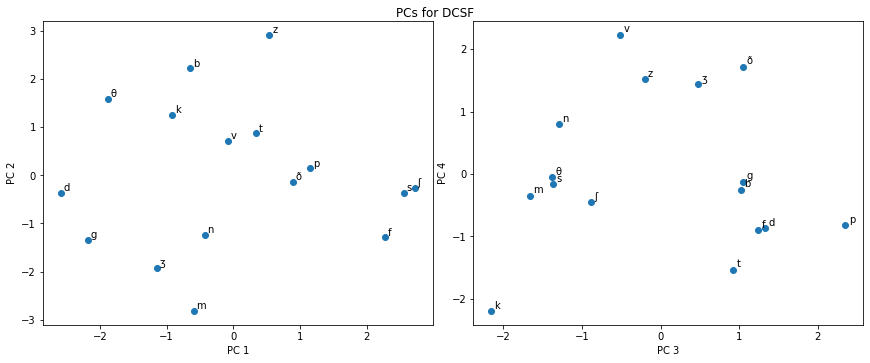

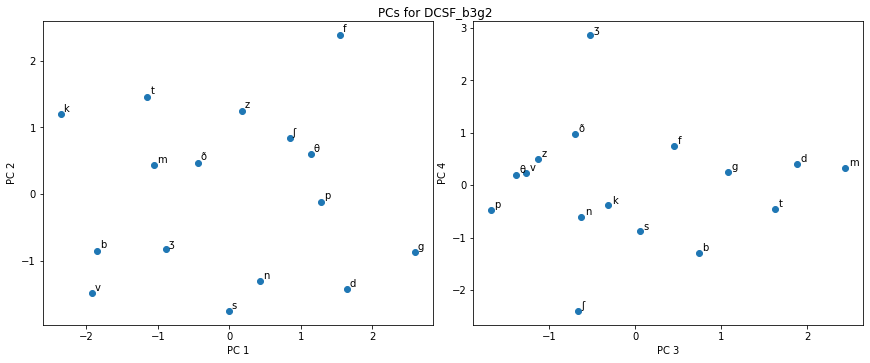

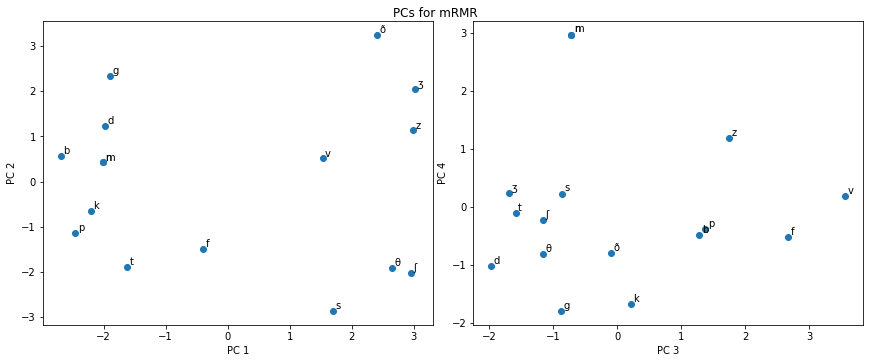

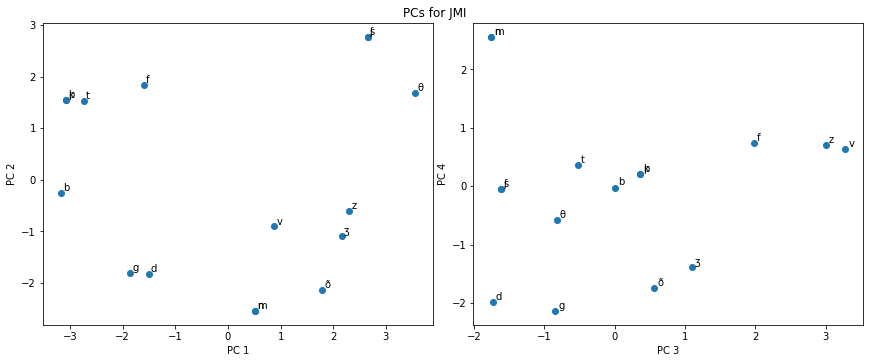

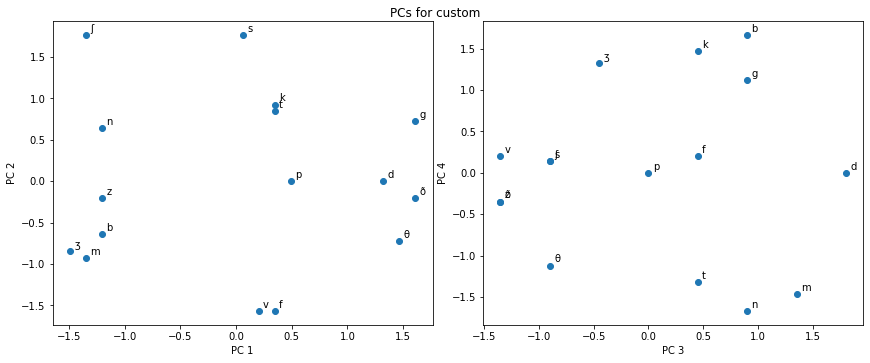

In [17]:
production.plot_pca('DCSF')
production.plot_pca('DCSF_b3g2')
production.plot_pca('mRMR')
production.plot_pca('JMI')
production.plot_pca('custom')

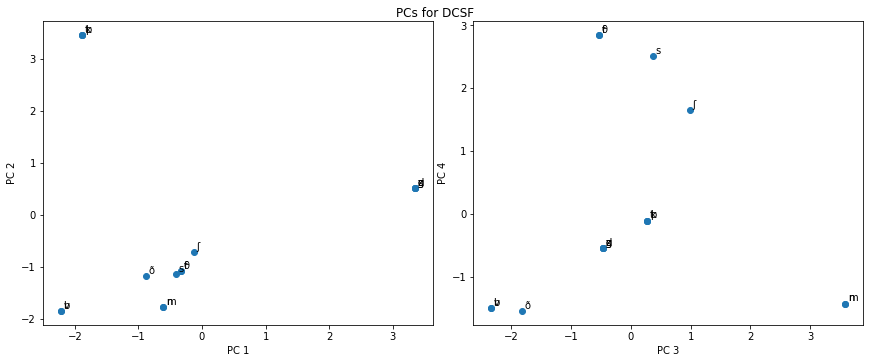

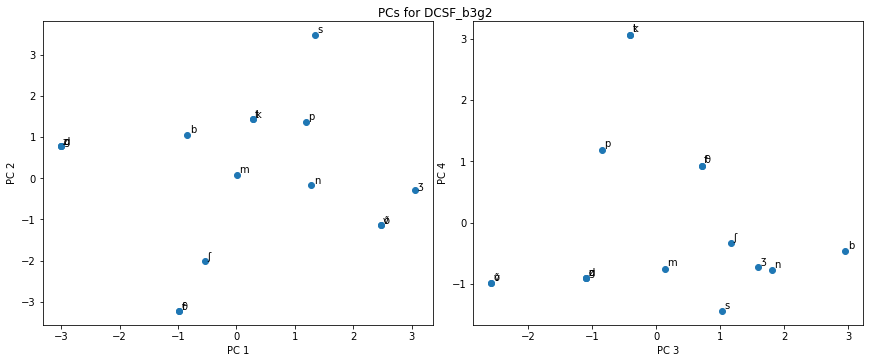

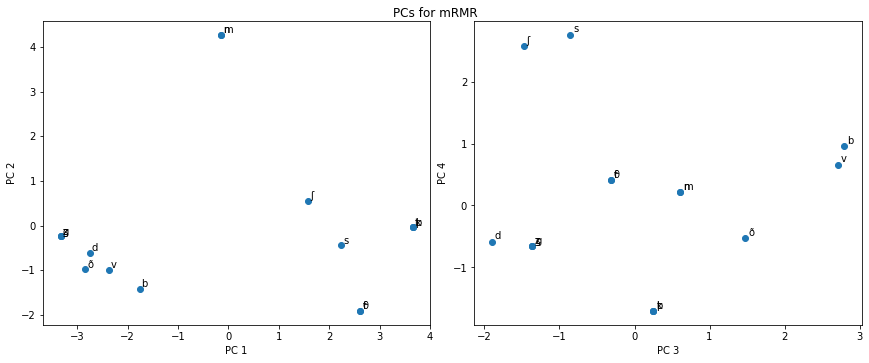

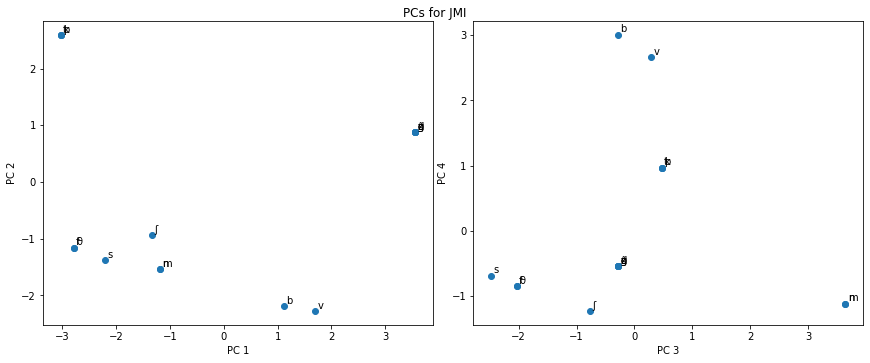

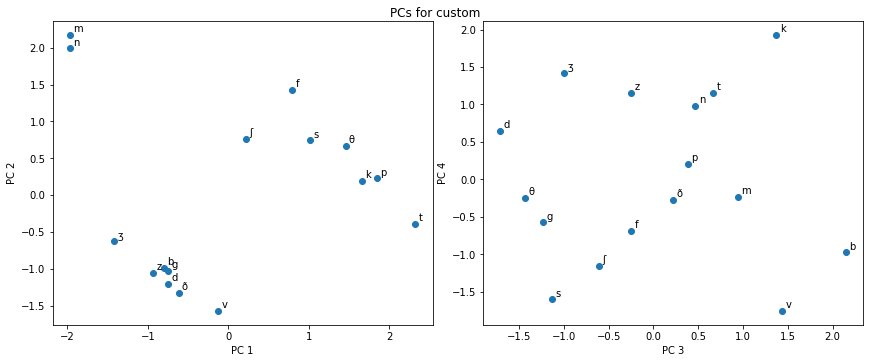

In [18]:
perception.plot_pca('DCSF')
perception.plot_pca('DCSF_b3g2')
perception.plot_pca('mRMR')
perception.plot_pca('JMI')
perception.plot_pca('custom')

## Mutual information between selected features and a priori articulatory features

In [19]:
consonants = ['p','t','k','f','θ','s','ʃ','b','d','g','v','ð','z','ʒ','m','n']

# read features from https://github.com/anna-hope/phonemes
with open("phonemes.json", "r") as read_file:
    data = json.load(read_file)

art_features = pd.DataFrame()
for c in consonants:
    art_features = pd.concat([art_features,pd.DataFrame.from_dict(data[c]['features'], orient='index')],axis=1)

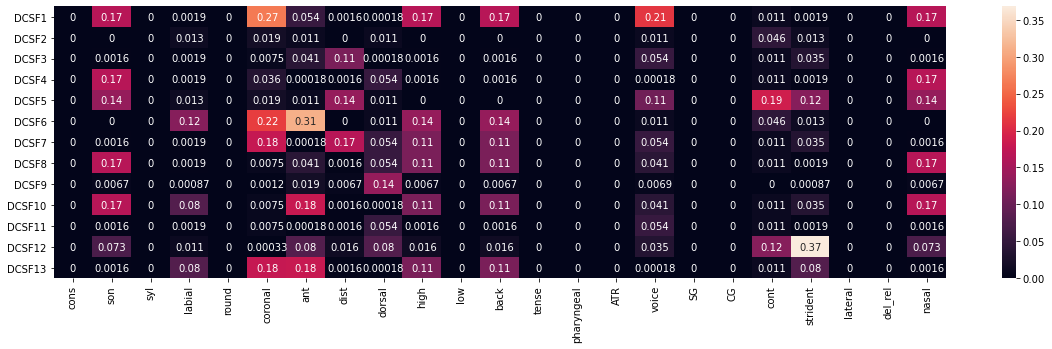

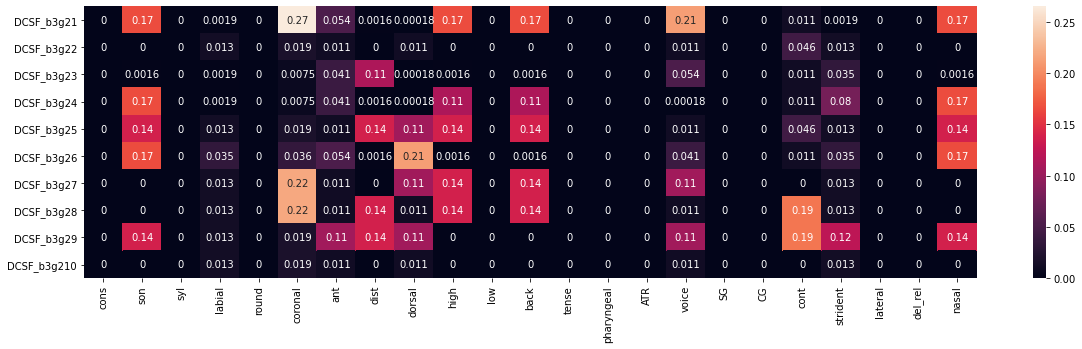

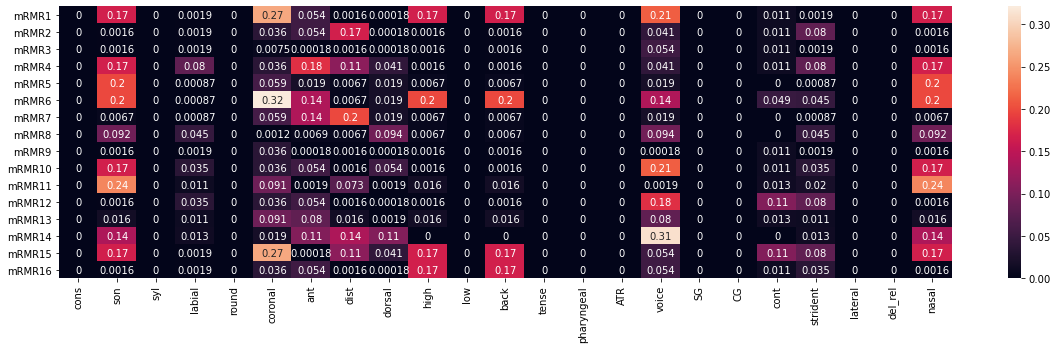

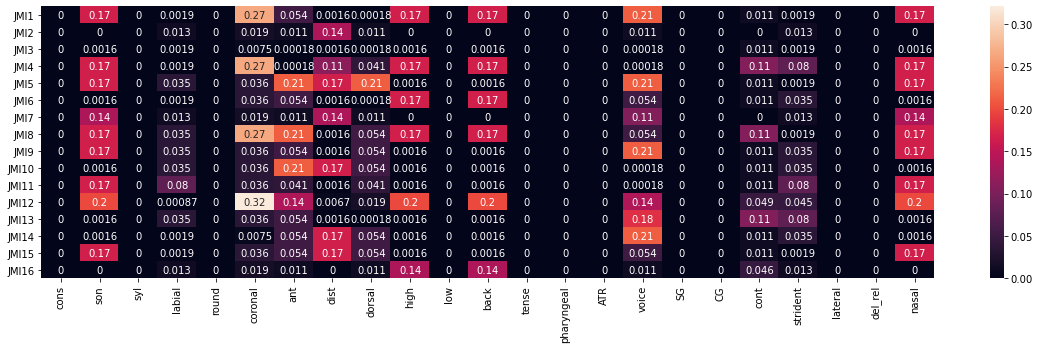

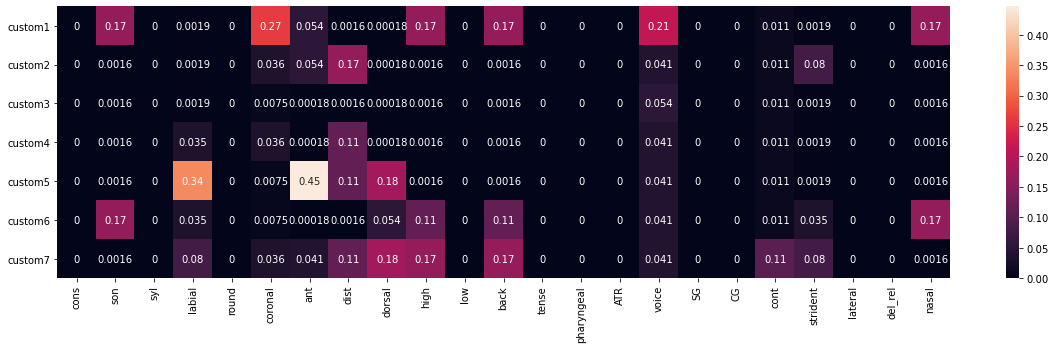

In [20]:
production.plot_articulatory_feature_MI(art_features)

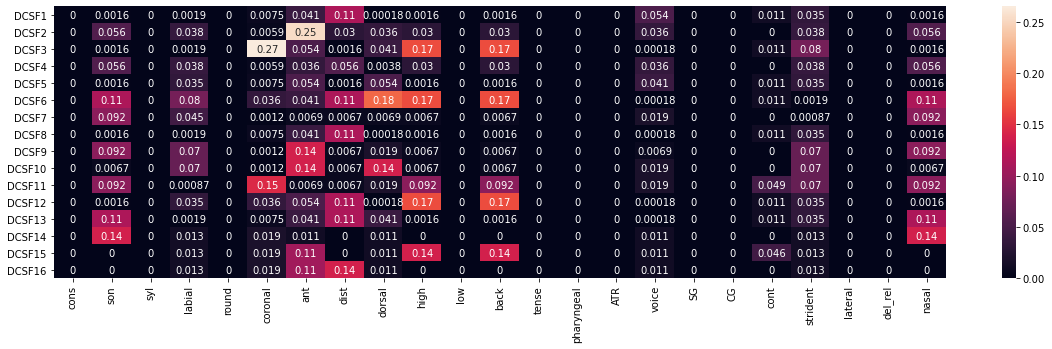

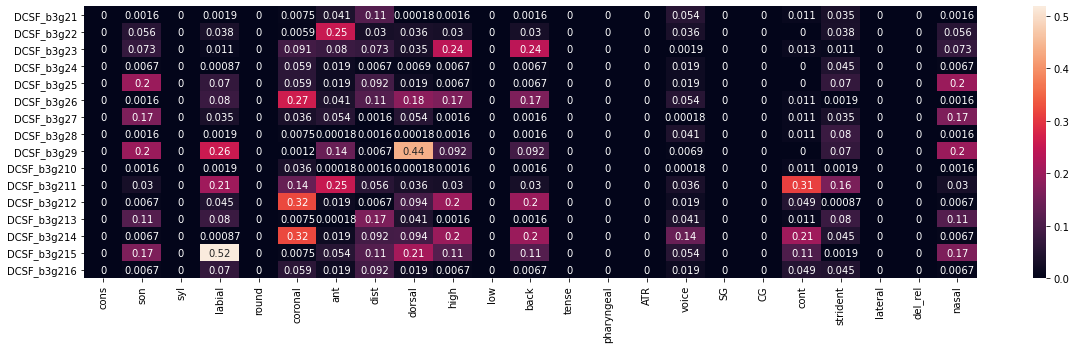

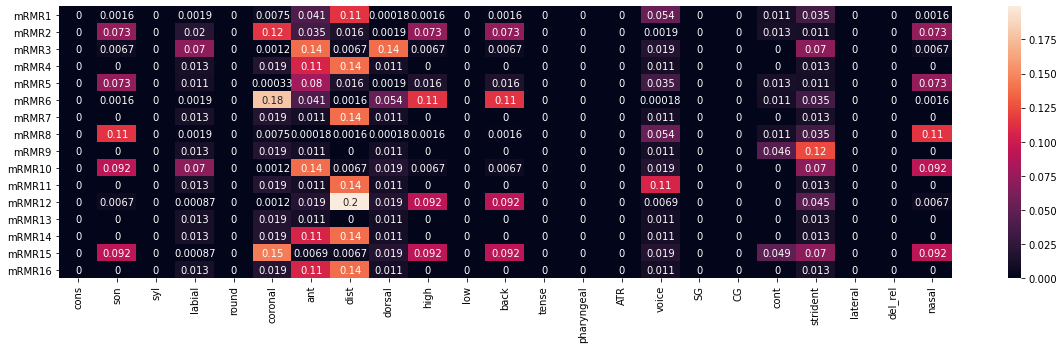

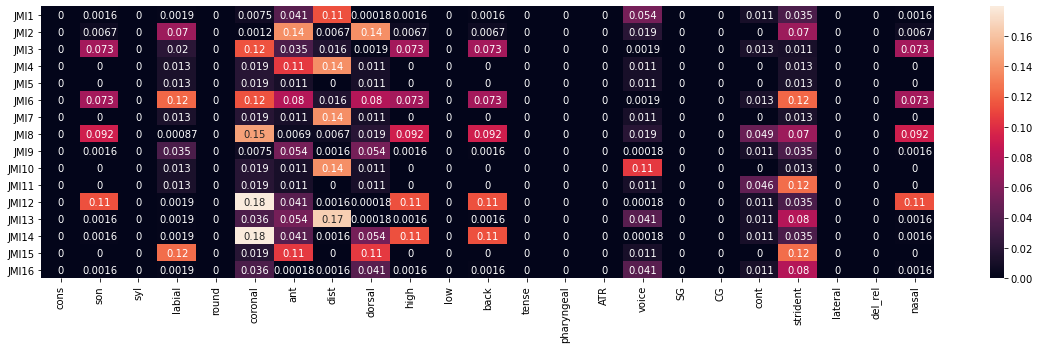

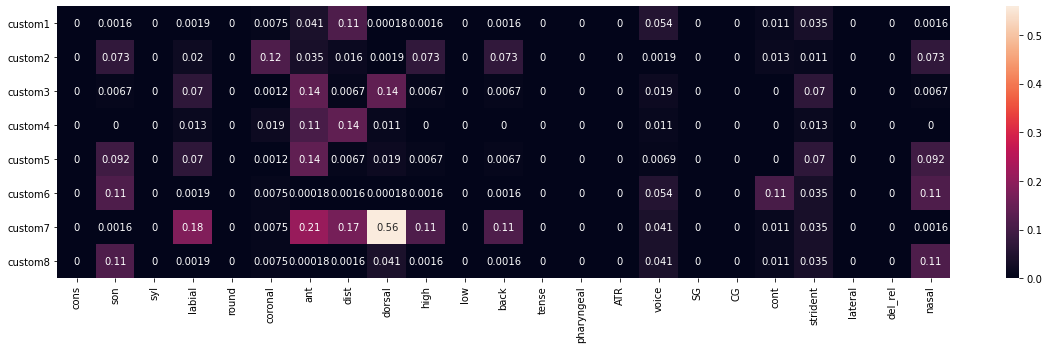

In [21]:
perception.plot_articulatory_feature_MI(art_features)